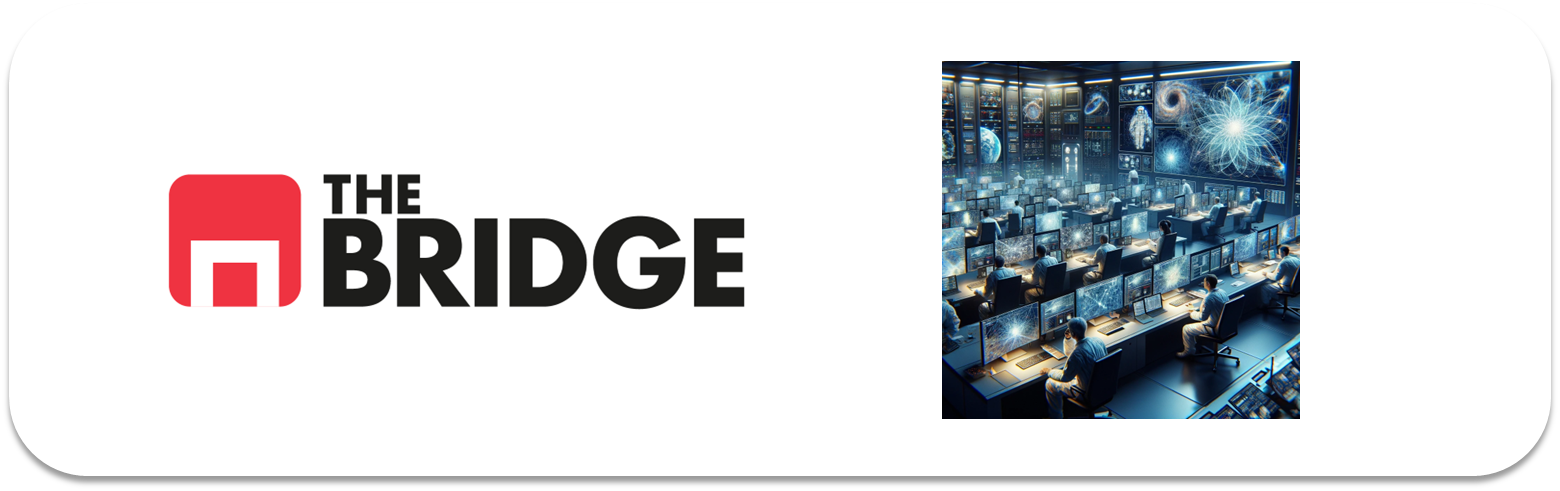

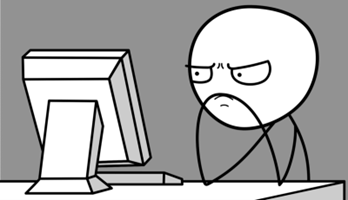

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [33]:
import os
import shutil

from time import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras._tf_keras import keras
from keras._tf_keras.keras.applications.resnet_v2 import (ResNet50V2,
                                                          decode_predictions,
                                                          preprocess_input)
from keras._tf_keras.keras.preprocessing import image
from skimage.io import imread
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from utils import consolepy

# Pylance not working
# from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.preprocessing import image

## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de imágenes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 imágenes por cada tipo. Tendrás que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificación de una menor cantidad de casos (sólo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teninendo en cuenta su distribución, para ello tendrás que explorar las estructura. Crea un juego Train,test para resolución 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [2]:
# Unzip files
zip_files = [
    './data/apples/Train.zip',
    './data/apples/Test.zip'
    ]

for zip_file in zip_files:
    consolepy.unzip_files(zip_file, './data/apples/')

Extracted ./data/apples/Train.zip to ./data/apples/
Extracted ./data/apples/Test.zip to ./data/apples/


In [2]:
# Importar los datos desde la carpeta de apples
TRAIN_PATH = './data/apples/Train'
TEST_PATH = './data/apples/Test'

# Tamaño de las imágenes
IM_SIZE_LQ = 32
IM_SIZE_HQ = 224

In [4]:
# Cargar cada imagen y su etiqueta del train
X_train = []
y_train = []

for category in os.listdir(TRAIN_PATH):
    print('Reading:', category)
    for file in os.listdir(os.path.join(TRAIN_PATH, category)):
        img = plt.imread(os.path.join(TRAIN_PATH, category, file))
        img = cv2.resize(img, (IM_SIZE_LQ, IM_SIZE_LQ))
        X_train.append(img)
        y_train.append(category)
        
# Transformamos a numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Verificamos que la carga de datos sea correcta
print(X_train.shape)
print(y_train.shape)

# Guardar las variables en archivos separados
np.save('./data/apples/X_train.npy', X_train)
np.save('./data/apples/y_train.npy', y_train)


Reading: Braeburn
Reading: CrimsonSnow
Reading: Golden1
Reading: Golden2
Reading: Golden3
Reading: GrannySmith
Reading: PinkLady
Reading: Red1
Reading: Red2
Reading: Red3
Reading: RedDelicious
Reading: RedYellow1
Reading: RedYellow2
(6404, 32, 32, 3)
(6404,)


In [5]:
# Cargamos los datos de test
X_test = []
y_test = []

for category in os.listdir(TEST_PATH):
    print('Reading:', category)
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (IM_SIZE_LQ, IM_SIZE_LQ))
        X_test.append(img)
        y_test.append(category)

# Transformamos a numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Verificamos que la carga de datos sea correcta
print(X_test.shape)
print(y_test.shape)

# Guardar las variables en archivos separados
np.save('./data/apples/X_test.npy', X_test)
np.save('./data/apples/y_test.npy', y_test)


Reading: Braeburn
Reading: CrimsonSnow
Reading: Golden1
Reading: Golden2
Reading: Golden3
Reading: GrannySmith
Reading: PinkLady
Reading: Red1
Reading: Red2
Reading: Red3
Reading: RedDelicious
Reading: RedYellow1
Reading: RedYellow2
(2134, 32, 32, 3)
(2134,)


*Tenemos bastantes manzanas de datos. Además son a color y en 32x32 de resolución. Vayamos con la visualización*

*Creamos también el juego de test con mayor resolución para que hacer Zero Shot Learning con ResNetv50, que exige ese tamaño.*

In [6]:
# Cargamos los datos de test con resolución HQ (224x224)
X_test_224 = []
y_test_224 = []

for category in os.listdir(TEST_PATH):
    print('Reading:', category)
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (IM_SIZE_HQ, IM_SIZE_HQ))
        X_test_224.append(img)
        y_test_224.append(category)

# Transformamos a numpy arrays
X_test_224 = np.array(X_test_224)
y_test_224 = np.array(y_test_224)

# Verificamos que la carga de datos sea correcta
print(X_test_224.shape)
print(y_test_224.shape)

# Guardar las variables en archivos separados
np.save('./data/apples/X_test_224.npy', X_test_224)
np.save('./data/apples/y_test_224.npy', y_test_224)

Reading: Braeburn
Reading: CrimsonSnow
Reading: Golden1
Reading: Golden2
Reading: Golden3
Reading: GrannySmith
Reading: PinkLady
Reading: Red1
Reading: Red2
Reading: Red3
Reading: RedDelicious
Reading: RedYellow1
Reading: RedYellow2
(2134, 224, 224, 3)
(2134,)


*Si hiciera falta, en vez de ejecutar la carga de imágenes puedo recuperar los datos en bruto directamente en formato numpy.*

In [3]:
# Cargar las variables guardadas
X_train = np.load('./data/apples/X_train.npy')
y_train = np.load('./data/apples/y_train.npy')
X_test = np.load('./data/apples/X_test.npy')
y_test = np.load('./data/apples/y_test.npy')
X_test_224 = np.load('./data/apples/X_test_224.npy')
y_test_224 = np.load('./data/apples/y_test_224.npy')

print(f"Training data: {type(X_train)}, {X_train.shape}, {y_train.shape}")
print(f"Test data: {type(X_test)}, {X_test.shape}, {y_test.shape}")
print(f"Test data (HQ): {type(X_test_224)}, {X_test_224.shape}, {y_test_224.shape}")

Training data: <class 'numpy.ndarray'>, (6404, 32, 32, 3), (6404,)
Test data: <class 'numpy.ndarray'>, (2134, 32, 32, 3), (2134,)
Test data (HQ): <class 'numpy.ndarray'>, (2134, 224, 224, 3), (2134,)


**NOTA:** A partir de aquí emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualización de algunos de los datos. Crea una función que te ayude con ello.

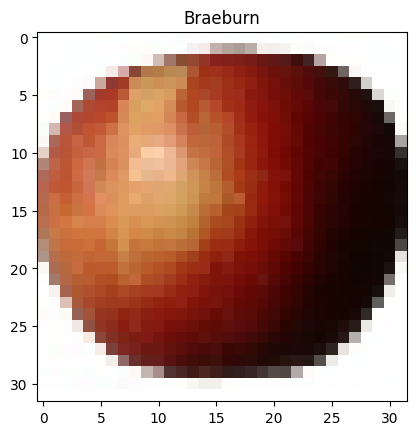

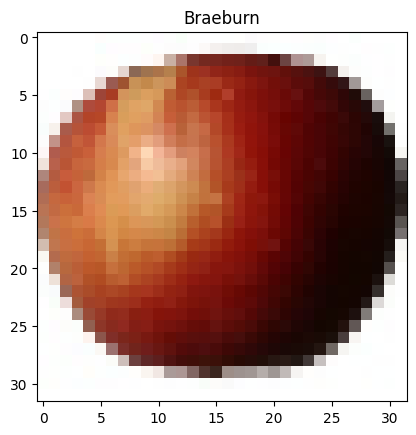

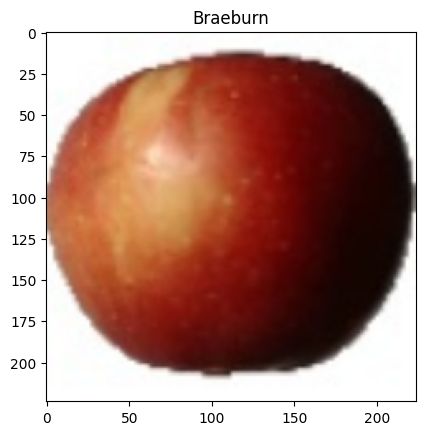

In [4]:
# Vamos a ver una imagen de train
plt.imshow(X_train[0])
plt.title(y_train[0])
plt.show()

# Una imagen de test (LQ) --> Casualidad es la misma que la del train
plt.imshow(X_test[0])
plt.title(y_test[0])
plt.show()

# Una imagen de test (HQ)
plt.imshow(X_test_224[0])
plt.title(y_test_224[0])
plt.show()

*Creamos ahora una función que espera "batches" de datos en formato numpy array*

In [5]:
def show_images_batch(apples, names=[], n_cols=5, size_scale=2):
    """
    Display a batch of images in a grid format.

    Parameters
    ----------
    apples : list or array-like
        A list or array of images to display.
    names : list, optional
        A list of titles for each image. If provided, each image will be 
        displayed with its corresponding title. Default is an empty list.
    n_cols : int, optional
        The number of columns in the grid. Default is 5.
    size_scale : float, optional
        A scaling factor to adjust the size of the displayed images. 
        Default is 2.

    Returns
    -------
    None
        The function displays the images but does not return any value.

    Notes
    -----
    The function calculates the required number of rows based on the total 
    number of images and the specified number of columns. It then creates 
    a grid layout to display the images. If the `names` list is provided, 
    each image will have a title. The size of the figure can be adjusted 
    using the `size_scale` parameter.
    """
    n_rows = ((len(apples) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1 * size_scale))
    for index, apple in enumerate(apples):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(apple)
        plt.axis("off")
        if len(names):
            plt.title(names[index])


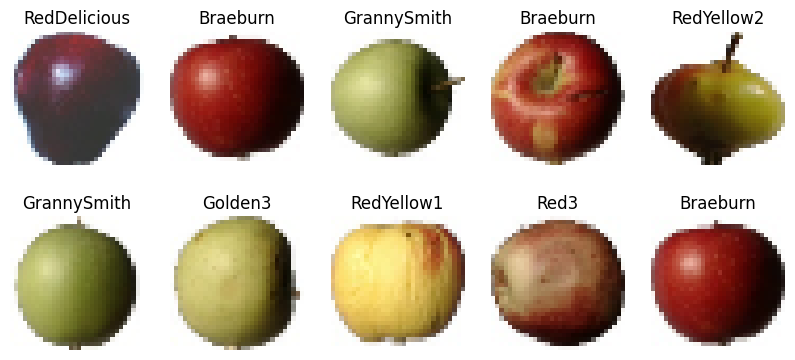

In [6]:
indexes = np.random.randint(0, len(X_train), 10)
show_images_batch(X_train[indexes], y_train[indexes])

*Veamos algunas de las de resolución 224x224*

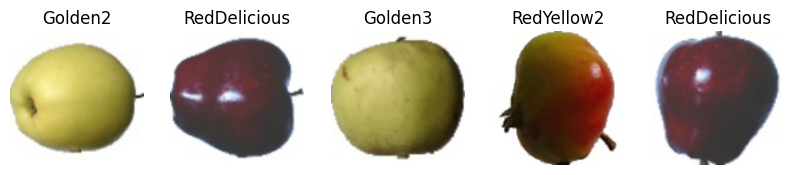

In [7]:
indexes = np.random.randint(0, len(X_test_224), 5)
show_images_batch(X_test_224[indexes], y_test_224[indexes])

### Ejercicio 3

Completa el miniEDA habitual con imágenes y escoge una métrica para el modelo.

In [8]:
# Distribución del target
pd.DataFrame(y_train).value_counts(normalize=True)

0           
RedYellow2      0.104934
Braeburn        0.076827
Golden2         0.076827
GrannySmith     0.076827
Red1            0.076827
Red2            0.076827
RedYellow1      0.076827
RedDelicious    0.076515
Golden3         0.075109
Golden1         0.074953
PinkLady        0.071205
CrimsonSnow     0.069332
Red3            0.066989
Name: proportion, dtype: float64

*Son bastantes categorías, mejor voy a pintarlas.*

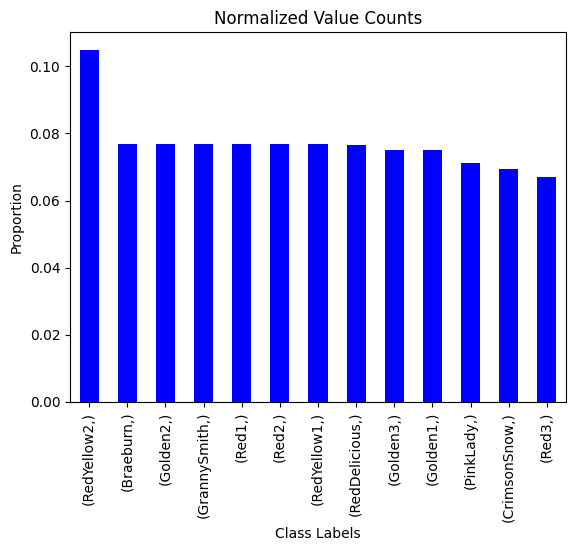

In [9]:
pd.DataFrame(y_train).value_counts(normalize=True).plot(kind='bar', color='blue')

plt.title('Normalized Value Counts')
plt.ylabel('Proportion')
plt.xlabel('Class Labels')
plt.show()

*Tenemos 13 clases y una distribución uniforme más o menos para todas salvo para la RedYellow2 que es un poco más mayoritaria.*

*En un caso real deberíamos probar a hacer un `UnderSampling` de esta categoría en caso de que el modelo no nos termine de gustar, para el resto de ejercicicos vamos a conformarnos con esta distribución y vamos a emplar la métrica de accuracy como buena*

### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la función shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [10]:
# Escalamos las imágenes
X_train = X_train / 255
X_test = X_test / 255

# Barajamos los datos. Interesa hacerlo con train puesto que de ellos aprende el modelo
X_train, y_train = shuffle(X_train, 
                           y_train, 
                           random_state=42
                           )

### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a numéricas, creando dos diccionarios uno que permita traducir de etiqueta a clase numérica y otro que permita la transformación inversa.

*Solución de Alberto:*


In [12]:
# Mapeamos las categorías a números y lo convertimos en diccionario
mapping = {cat: i for i, cat in enumerate(np.unique(y_train))}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}

display(mapping)
display(inverse_mapping)

# Mapeamos las etiquetas
y_train_num = np.array([mapping[cat] for cat in y_train])
y_test_num = np.array([mapping[cat] for cat in y_test])

{'Braeburn': 0,
 'CrimsonSnow': 1,
 'Golden1': 2,
 'Golden2': 3,
 'Golden3': 4,
 'GrannySmith': 5,
 'PinkLady': 6,
 'Red1': 7,
 'Red2': 8,
 'Red3': 9,
 'RedDelicious': 10,
 'RedYellow1': 11,
 'RedYellow2': 12}

{0: 'Braeburn',
 1: 'CrimsonSnow',
 2: 'Golden1',
 3: 'Golden2',
 4: 'Golden3',
 5: 'GrannySmith',
 6: 'PinkLady',
 7: 'Red1',
 8: 'Red2',
 9: 'Red3',
 10: 'RedDelicious',
 11: 'RedYellow1',
 12: 'RedYellow2'}

*Aunque va en contra del enunciado, prefiero hacer el codificado de las etiquetas con un `LabelEncoder` de sklearn.*

In [14]:
# Codificado del target
le = LabelEncoder()

y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

# Mostrar el mapeo original --> codificado
for original_class, encoded_class in zip(le.classes_, range(len(le.classes_))):
    print(f"{original_class} --> {encoded_class}")

Braeburn --> 0
CrimsonSnow --> 1
Golden1 --> 2
Golden2 --> 3
Golden3 --> 4
GrannySmith --> 5
PinkLady --> 6
Red1 --> 7
Red2 --> 8
Red3 --> 9
RedDelicious --> 10
RedYellow1 --> 11
RedYellow2 --> 12


In [13]:
y_train

array(['GrannySmith', 'RedYellow1', 'GrannySmith', ..., 'RedDelicious',
       'RedYellow1', 'CrimsonSnow'], dtype='<U12')

In [15]:
y_train_num

array([ 5, 11,  5, ..., 10, 11,  1], dtype=int64)

### Ejercicio 6: Zero Shot Learning

Descargar el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pruébalo contra el test (aquí no valen nuestras categorías serán las que proporcione ResNet ojo). Prueba una selección aleatoria de imágenes del test y compara las etiquetas de ResNet con la que tiene. ¿Nos sirve este clasificador así tal cual?


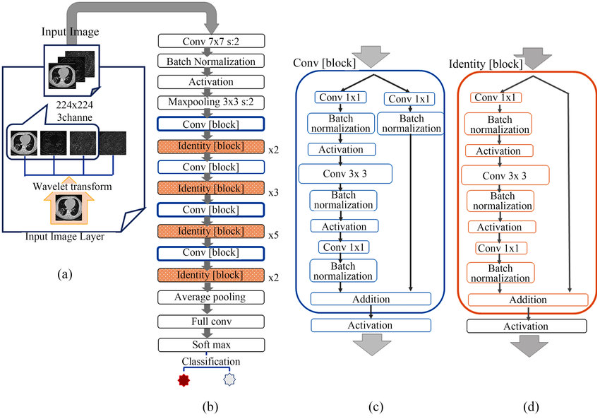

*Nota: si intento usar las imágenes de 32x32 dará error porque ResNet50V2 tiene el input_shape limitado a imagenes de tamaño 224x224*

In [16]:
'''
imagenet es un corpus de imagenes con el que se ha clasificado el ResNet50V2
http://www.image-net.org/

Cargamos toda la red ya entrenada, y la usaremos para predecir
include_top=True --> Para que incluya la fully connected layer.
include_top=False --> Desarrollamos la fully connected layer
ojo el input shape que sea el de las imagenes que introduciremos. Esta limitado a imagenes de tamaño 224x224
classifier_activation se usa si include_top=True
'''

# include_top=True --> Como vamos a emplearla directamente, incluimos también la parte de 
# capas densas que hacen la predicción en este caso clasificación de imagenes.
# weights="imagenet" --> Se carga con los pesos entrenados para el dataset de imagenet
base_model = ResNet50V2(input_shape=(IM_SIZE_HQ, IM_SIZE_HQ, 3),
                        include_top=True,   
                        weights="imagenet", 
                        classifier_activation="softmax")

In [17]:
# Predicciones sobre una selección aletaria del set
selection = np.random.randint(0, len(X_test_224), 10)
pred_proba = base_model.predict(X_test_224[selection])
display(pred_proba)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
decode_predictions(pred_proba)[0]

[('n02883205', 'bow_tie', 1.0),
 ('n15075141', 'toilet_tissue', 0.0),
 ('n02317335', 'starfish', 0.0),
 ('n02389026', 'sorrel', 0.0),
 ('n02364673', 'guinea_pig', 0.0)]

In [19]:
decode_predictions(pred_proba)[0][0]

('n02883205', 'bow_tie', 1.0)

In [20]:
decode_predictions(pred_proba)[0][0][1]

'bow_tie'

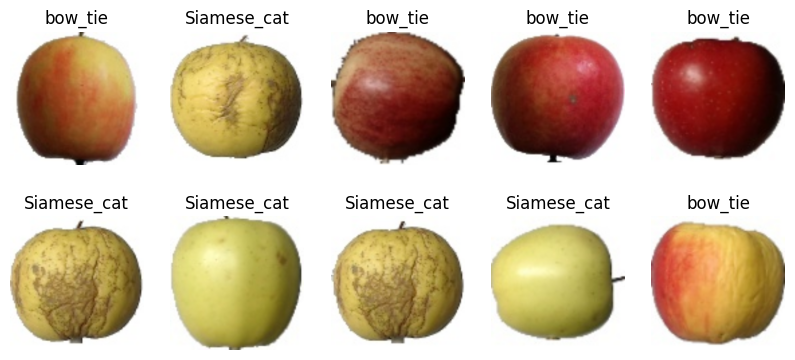

In [21]:
pred_class = [decoded[0][1] for decoded in decode_predictions(pred_proba)]
show_images_batch(X_test_224[selection], names=pred_class)

*Un pequeño... desastre, porque las clases no coinciden con las nuestras, otra cosa es que clasifique en clases similares las imágenes y pudieramos hacernos un mapeador. Es necesario transfer_learning o fine_tunning*

## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activación "relu") y otra de salida con las unidades que crees necesarias y activación la que consideres. Congela las capas del modelo base (la ResNet50). Define también los hiperparámetros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [22]:
# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(include_top=False, 
                        weights='imagenet', 
                        input_shape=(IM_SIZE_LQ, IM_SIZE_LQ, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
def prepare_TL_model(base_model):
    """
    Prepara y compila un modelo de red neuronal utilizando un modelo base.
    """
    # Capa de flatenizado de la salida del modelo base
    x = keras.layers.Flatten()(base_model.output)

    # Capa densa con 300 neuronas
    x = keras.layers.Dense(300, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.5)(x)

    # Capa final de salida con 13 neuronas y activación softmax
    x = keras.layers.Dense(13, activation='softmax')(x)

    model = keras.Model(base_model.input, x)
    
    model.compile(optimizer="adam", 
                  loss='sparse_categorical_crossentropy', 
                  metrics = ['acc'])
    
    return model

# Observamos la arquitectura del modelo
model = prepare_TL_model(base_model=base_model)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 618,613 (2.36 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evolución del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el número de épocas.

*Para escoger el batch_size (si no queremos usar el "clásico" 32):*

In [23]:
X_train.shape

(6404, 32, 32, 3)

In [24]:
train_instances = len(X_train)
for i in range(1, 5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(train_instances/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 200
Batch_size: 64, num_steps_per_epoch: 100
Batch_size: 96, num_steps_per_epoch: 67
Batch_size: 128, num_steps_per_epoch: 50


~~*Pues vamos a por batches de 64 que sería un número mágico 100 steps por época, esto es totalmente "intuitivo".*~~

*Mejor pensado, y aprovechando que tengo capacidad computacional, voy a emplear un batch size de 128. Para ello, antes, voy a ver cuánto tiempo tarda en ralizar un única época.*

In [25]:
# Entrenar el modelo con EarlyStopping
batch_size = 128
epochs = 1

model = prepare_model(base_model=base_model)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=5,
                                                 restore_best_weights=True)

t_init = time()
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cb_earlystopping],
                    validation_split=0.2
                    )
t_end = time()
print('Fit time:', t_end - t_init, 'seconds.')

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - acc: 0.3798 - loss: 2.3770 - val_acc: 0.9048 - val_loss: 0.4099
Fit time: 11.57503342628479 seconds.


*Bueno, en mi caso 12 segundos, y una accuracy desmedida (malísima) en validación, tiene pinta de que el overfitting es del bueno... lo veremos cuando evaluemos contra test*

*Ahora sí voy a aumentar el número de épocas y entrenar el modelo. `IMPORTANTE` volver a crear el modelo base, para que no siga entrenando desde donde se quedó la última vez.*

Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - acc: 0.4132 - loss: 2.1864 - val_acc: 0.9048 - val_loss: 0.3956
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - acc: 0.8291 - loss: 0.5103 - val_acc: 0.9649 - val_loss: 0.1904
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - acc: 0.9314 - loss: 0.2434 - val_acc: 0.9836 - val_loss: 0.1093
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - acc: 0.9576 - loss: 0.1616 - val_acc: 0.9727 - val_loss: 0.0912
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - acc: 0.9245 - loss: 0.2414 - val_acc: 0.9938 - val_loss: 0.0536
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - acc: 0.9775 - loss: 0.0942 - val_acc: 0.9977 - val_loss: 0.0333
Epoch 7/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - acc: 0.9875 - loss: 0.0679 - val_acc: 0.9977 - val_loss: 0.0260
Epoch 8/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - acc: 0.9892 - loss: 0.0519 - val_acc: 0.9992 - val_loss: 0.0190
Epoch 9/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - a

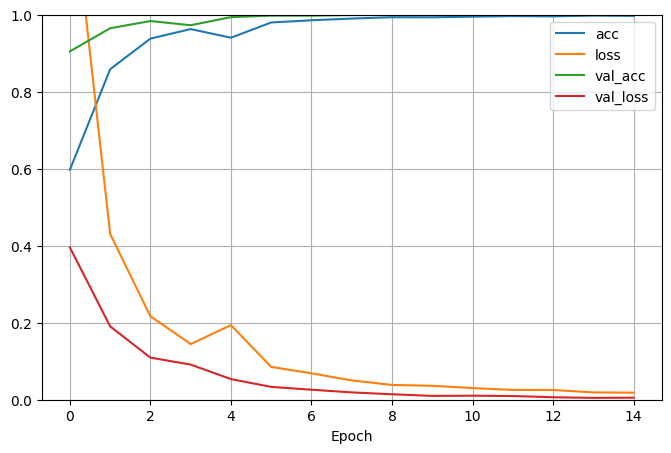

In [29]:
# Entrenar el modelo con EarlyStopping
batch_size = 128
epochs = 15

model = prepare_TL_model(base_model=base_model)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=5,
                                                 restore_best_weights=True)

t_init = time()
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cb_earlystopping],
                    validation_split=0.2
                    )
t_end = time()
print('Fit time:', t_end - t_init, 'seconds.')

# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.show()

*Claramente (incluso sin pintar la evolución) los valores de accuracy son exageradamente altos, y hay que pensar que una ResNet permite overfittear, por lo que habría que buscar alguna manera de regularizar más, por ejemplo metiendo regularización L2 en el optimizador con el parámetros weight_decay o haciéndolo directamente en cada capa (consultar la docu de Keras). En el siguiente ejercicio veremos hasta que punto disminuye esa accuracy respecto al test*

*Además, la pérdida sigue cayendo. Podríamos haber creado algún tipo de tolerancia para no añadir épocas innecesariamente. Por ejemplo:*

Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - acc: 0.3824 - loss: 2.5458 - val_acc: 0.9016 - val_loss: 0.4378
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - acc: 0.8426 - loss: 0.5061 - val_acc: 0.9649 - val_loss: 0.1960
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - acc: 0.9255 - loss: 0.2588 - val_acc: 0.9820 - val_loss: 0.1150
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - acc: 0.9600 - loss: 0.1612 - val_acc: 0.9945 - val_loss: 0.0630
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - acc: 0.9649 - loss: 0.1290 - val_acc: 0.9953 - val_loss: 0.0474
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - acc: 0.9800 - loss: 0.0863 - val_acc: 0.9992 - val_loss: 0.0278
Epoch 7/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - acc: 0.9864 - loss: 0.0615 - val_acc: 0.9969 - val_loss: 0.0292
Epoch 8/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - acc: 0.9713 - loss: 0.0968 - val_acc: 0.9984 - val_loss: 0.0234
Epoch 9/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - a

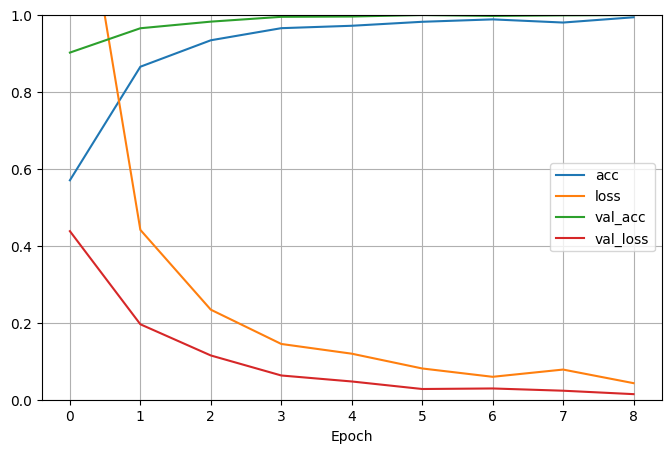

In [31]:
# Entrenar el modelo con EarlyStopping modificado
batch_size = 128
epochs = 15

model = prepare_TL_model(base_model=base_model)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 min_delta=0.1, 
                                                 patience=5,
                                                 restore_best_weights= True
                                                 )

t_init = time()
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cb_earlystopping],
                    validation_split=0.2
                    )
t_end = time()
print('Fit time:', t_end - t_init, 'seconds.')

# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.show()

### Ejercicio 9

Evalua el modelo contra test y haz un pequeño análisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un pequeño análisis de errores.

In [32]:
# Evaluamos el modelo
model.evaluate(X_test, y_test_num)

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - acc: 0.8615 - loss: 0.4568


[0.519518256187439, 0.8402062058448792]

*Como tendríamos que esperar el modelo con tanta potencia hace overfitting, además de las posibles regularizaciones, inclusión de dropout quizás podríamos reducir las unidades de la capa densa, en cualquier caso es más de un 80% de accuracy para empezar, no está mal, sin haber tocado nada más.*

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
              precision    recall  f1-score   support

    Braeburn       0.69      0.98      0.81       164
 CrimsonSnow       1.00      0.78      0.87       148
     Golden1       0.75      0.99      0.85       160
     Golden2       0.97      0.80      0.88       164
     Golden3       0.60      0.64      0.62       161
 GrannySmith       1.00      0.77      0.87       164
    PinkLady       0.76      0.99      0.86       152
        Red1       0.97      0.77      0.86       164
        Red2       0.60      0.53      0.56       164
        Red3       0.96      0.65      0.77       144
RedDelicious       1.00      0.99      1.00       166
  RedYellow1       0.86      0.96      0.91       164
  RedYellow2       1.00      1.00      1.00       219

    accuracy                           0.84      2134
   macro avg       0.86      0.83      0.83      2134
weighted avg       0.86      0.84      0.84      2134



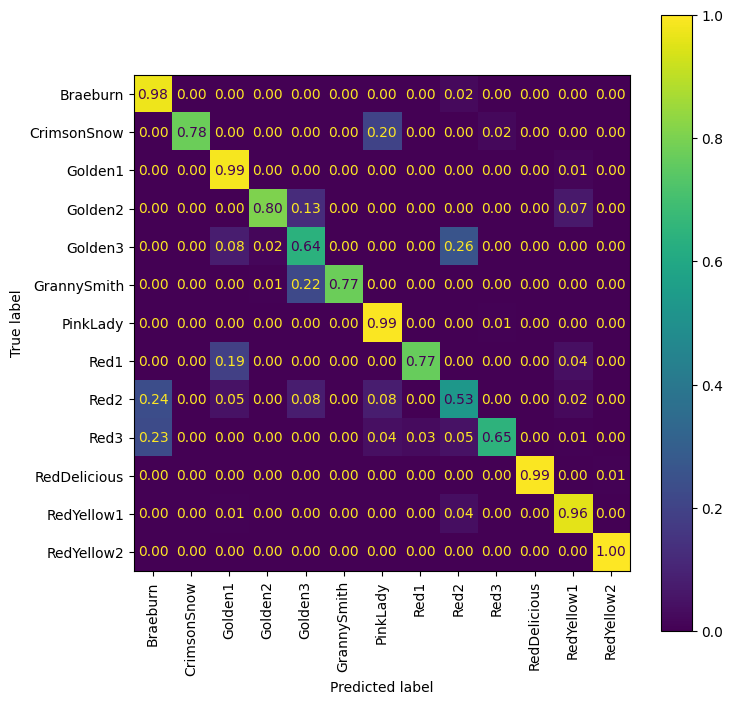

In [52]:
# Predicción
y_pred_num = np.array([np.argmax(pred_proba) for pred_proba in model.predict(X_test)])
y_pred = le.inverse_transform(y_pred_num)

# Classification Report
print(classification_report(y_test, y_pred))

# Matriz de confusión
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", ax=ax, values_format='.2f')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

*No está nada mal, aunque hay algún tipo que deja un poco que desear, en concreto el Golden3 que tiende a confundirse con Golden1 y con Red2. Y luego hay aciertos espectaculares como las RedX (Deliciousm Yellow1, Yellow2) y la Golden tipo 1 o la golden tipo 2, y las Breaburn.*

*Visualmente, veamos algunos de los errores a partir de un dataframe de resultados*

In [53]:
results = pd.DataFrame({"True": y_test, "Predicted": y_pred})

errors = results["True"] != results["Predicted"]
is_Golden3 = results["True"] == "Golden3"
predicted_Red2 = results["Predicted"] == "Red2"
is_Red2 = results["True"] == "Red2"


*Mostramos las Golden3 que ha confundido el modelo con Red2, hay que tener en cuenta que las Golden3 son de las que peor se le dan*

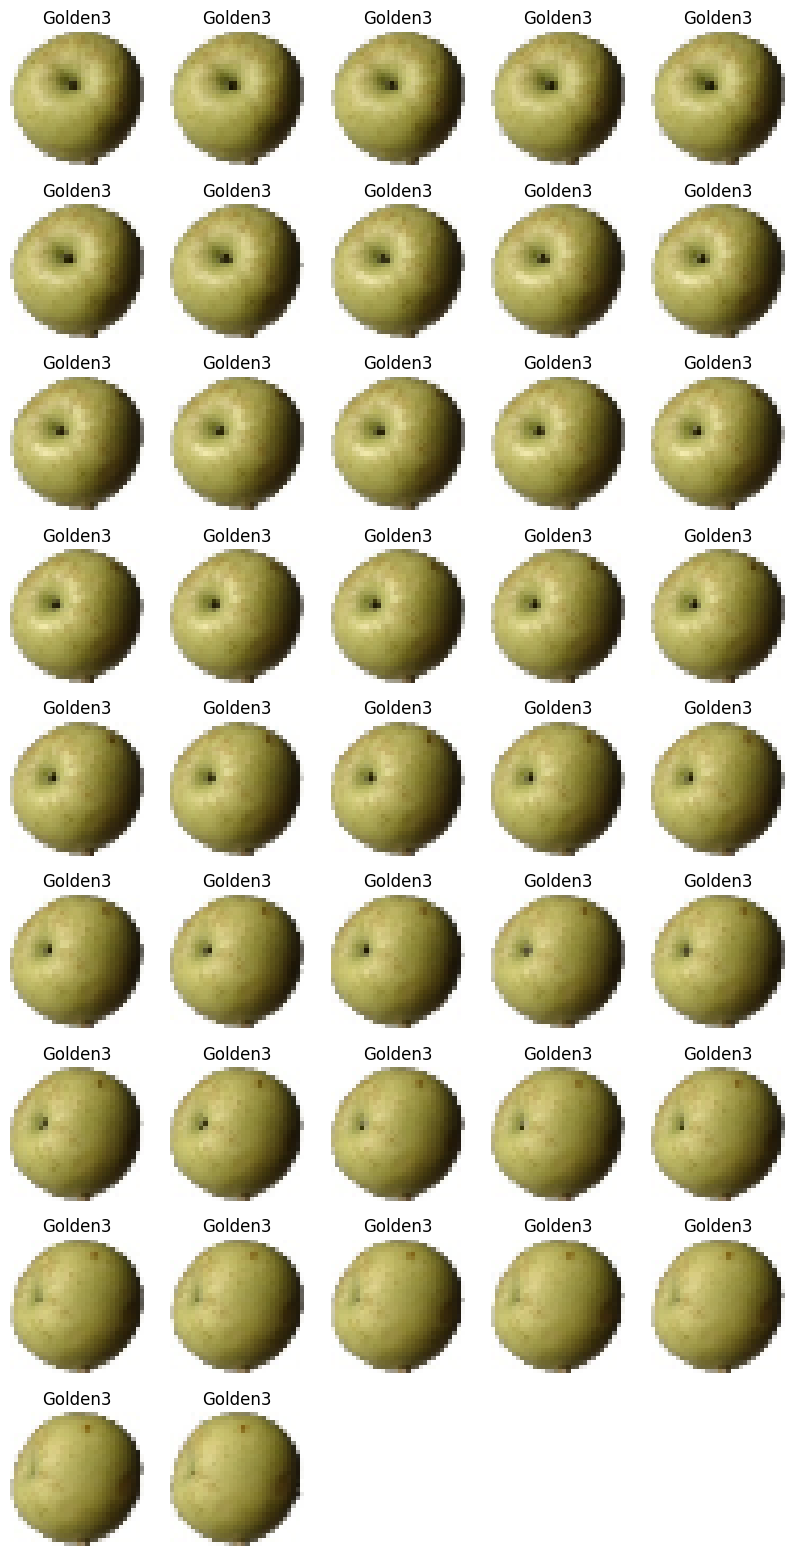

In [54]:
show_images_batch(X_test[results[is_Golden3 & predicted_Red2].index],
                  y_test[results[is_Golden3 & predicted_Red2].index])

*Para comparar unas Red2 que detecta correctamente*

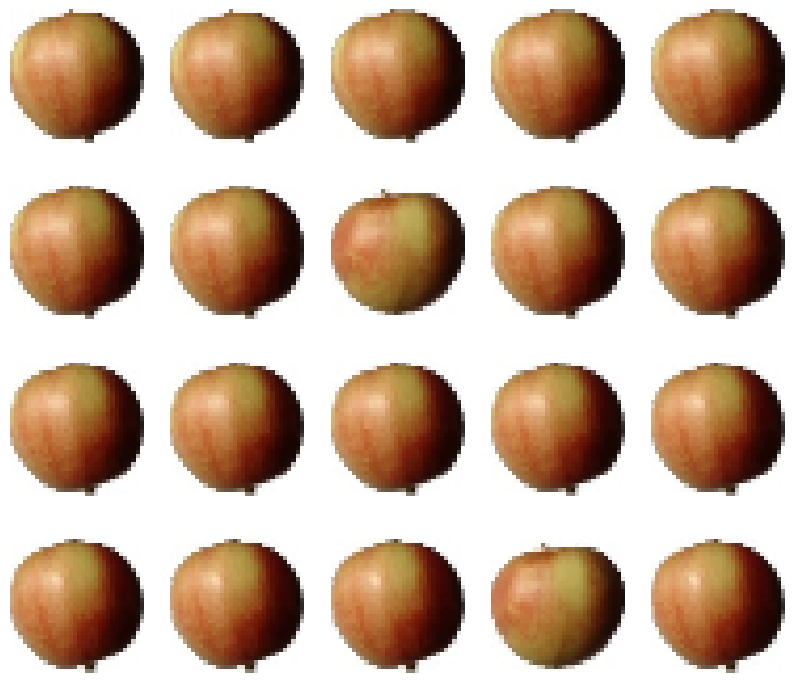

In [56]:
show_images_batch(X_test[results[is_Red2 & predicted_Red2].index[20:40]])

*Y algunas Golden3 bien etiquetadas*

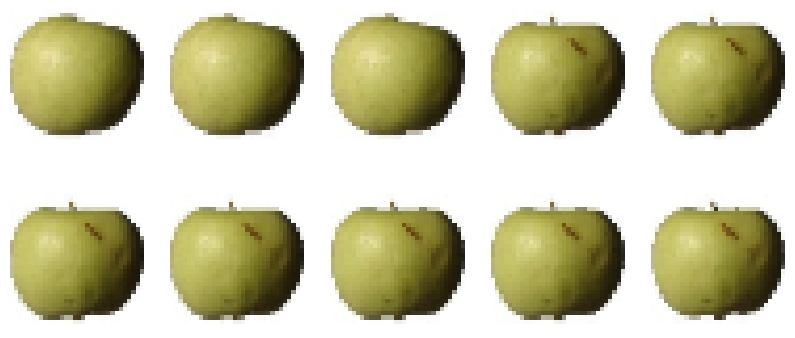

In [57]:
show_images_batch(X_test[results[is_Golden3 & (errors == False)].index[0:10]])


*Curiosos errores.*

## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

In [60]:
# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(include_top=False, 
                        weights=None, 
                        input_shape=(IM_SIZE_LQ, IM_SIZE_LQ, 3))

# Ahora NO quiero congelar las capas del modelo base
# for layer in base_model.layers:
#     layer.trainable = False

# Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
def prepare_FT_model(base_model):
    """
    Prepara y compila un modelo de red neuronal utilizando un modelo base.
    """
    # Capa de flatenizado de la salida del modelo base
    x = keras.layers.Flatten()(base_model.output)

    # Capa densa con 300 neuronas
    x = keras.layers.Dense(300, activation='relu')(x)
    x = keras.layers.Dropout(rate=0.5)(x)

    # Capa final de salida con 13 neuronas y activación softmax
    x = keras.layers.Dense(13, activation='softmax')(x)

    model = keras.Model(base_model.input, x)
    model.compile(optimizer="adam", 
                  loss='sparse_categorical_crossentropy', 
                  metrics = ['acc']
                  )
    return model

# Observamos la arquitectura del modelo
model= prepare_model(base_model=base_model)
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 24,137,973 (92.08 MB)

 Non-trainable params: 45,440 (177.50 KB)

### Ejercicio 11
Entrena con batch_size a 64 y 60 épocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente más largo, así que tómate un descanso). Muestra la evolución y da una posible justificación a emplear tantas épocas de partida.

Epoch 1/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 51s 416ms/step - acc: 0.8015 - loss: 0.7055 - val_acc: 0.1733 - val_loss: 11.5308
Epoch 2/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 398ms/step - acc: 0.8941 - loss: 0.3968 - val_acc: 0.4879 - val_loss: 4.0032
Epoch 3/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 400ms/step - acc: 0.9343 - loss: 0.2444 - val_acc: 0.2802 - val_loss: 12.5573
Epoch 4/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 401ms/step - acc: 0.9401 - loss: 0.2203 - val_acc: 0.7713 - val_loss: 2.7121
Epoch 5/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 396ms/step - acc: 0.9759 - loss: 0.0908 - val_acc: 0.9899 - val_loss: 0.0467
Epoch 6/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 396ms/step - acc: 0.9850 - loss: 0.0656 - val_acc: 0.4317 - val_loss: 7.2441
Epoch 7/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 404ms/step - acc: 0.9440 - loss: 0.2339 - val_acc: 0.1374 - val_loss: 42.5408
Epoch 8/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 384ms/step - acc: 0.8909 - loss: 0.5106 - val_acc: 0.1296 - val_loss: 58.4864
Epoch 9/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 38

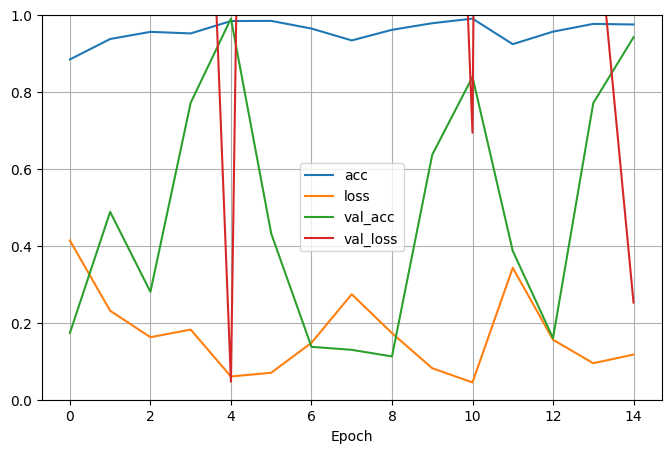

In [62]:
batch_size = 64
epochs = 60

model = prepare_FT_model(base_model=base_model)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=10,
                                                 restore_best_weights=True
                                                 )

# Entrenamos el modelo
t_init = time()
history = model.fit(X_train,
                    y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[cb_earlystopping]
                    )
t_end = time()
print('Fit time:', t_end - t_init, 'seconds.')

# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.show()

*Vamos a deshacer el zoom para ver las oscilaciones de "val_loss".*

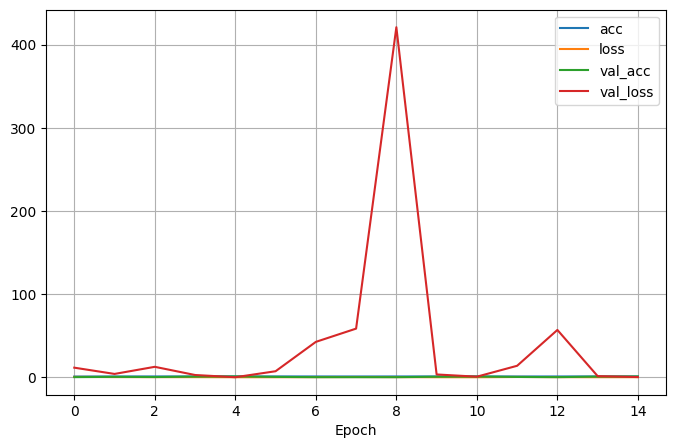

In [69]:
# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 90)
plt.xlabel('Epoch')
plt.show()

*EL problema con redes tan grandes y la cantidad de datos que tenemos es que la oscilación de los resultados es tremenda y la sensibilidad a la inicialización también. El modelo tarda en encontrar valores de pérdida bajos para validación y si repites el entrenamiento puede que tarde mucho más o menos en encontrar valores interesantes. Quizá vendría bien aumentar el batch size para que la selección aleatoria le afecte menos. Lo que sí ocurre es que si escogemos valores bajos de número de épocas es posible que el modelo nunca llegue a "calentar" como para salir de los mínimos locales que ha ido encontrando y no obtenga buenas prestaciones. Como puedes ver un finetuning de modelos grandes necesita de ... datos y paciencia*

### Ejercicio 12

Muestra la evaluación contra el test, el informe de clasificación  y la matriz de confusión. Compara los resultados con los del ejercicio 9.

In [63]:
model.evaluate(X_test, y_test_num)

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - acc: 0.9440 - loss: 0.1637


[0.11862101405858994, 0.9653233289718628]

*Para este test set la paciencia y el supermodelo han sido un buen ejemplo, por lo menos para esta ejecución, puede que otro no salga tan bueno*

67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step
              precision    recall  f1-score   support

    Braeburn       1.00      0.90      0.95       164
 CrimsonSnow       1.00      1.00      1.00       148
     Golden1       1.00      0.78      0.87       160
     Golden2       0.85      1.00      0.92       164
     Golden3       0.88      1.00      0.94       161
 GrannySmith       1.00      1.00      1.00       164
    PinkLady       1.00      1.00      1.00       152
        Red1       1.00      0.99      1.00       164
        Red2       0.89      0.87      0.88       164
        Red3       1.00      1.00      1.00       144
RedDelicious       1.00      1.00      1.00       166
  RedYellow1       0.95      1.00      0.98       164
  RedYellow2       1.00      1.00      1.00       219

    accuracy                           0.97      2134
   macro avg       0.97      0.96      0.96      2134
weighted avg       0.97      0.97      0.96      2134



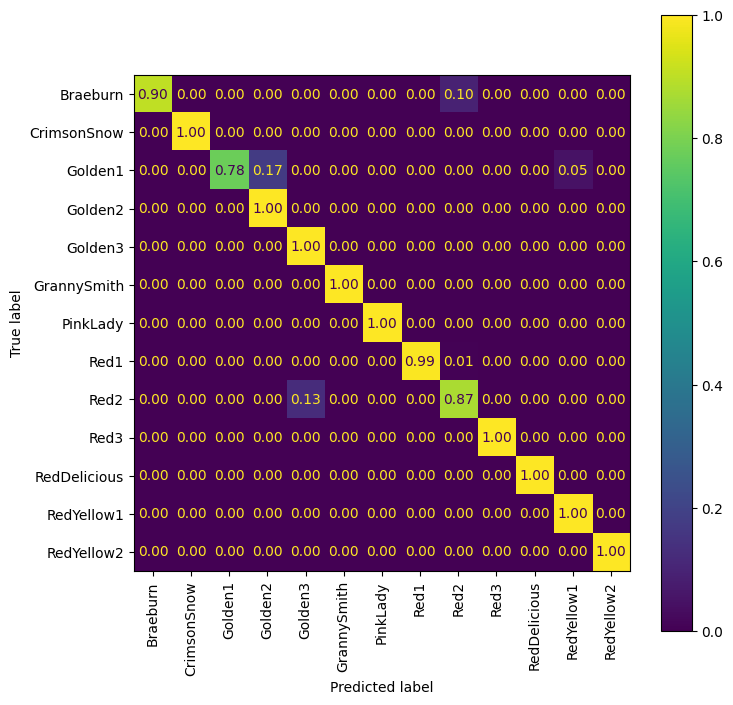

In [64]:
# Predicción
y_pred_num = np.array([np.argmax(pred_proba) for pred_proba in model.predict(X_test)])
y_pred = le.inverse_transform(y_pred_num)

# Classification Report
print(classification_report(y_test, y_pred))

# Matriz de confusión
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", ax=ax, values_format='.2f')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

*En esta ejecución, Golden_1 tiene el recall más bajo, podría volver a entrenar con un earlystop mayor.*

### Eliminar ficheros y carpetas


In [70]:
# Eliminar todas las carpetas creadas en este notebook
data_path = './data/apples/'
consolepy.remove_non_zip_folders(data_path)
consolepy.remove_npy_files(data_path)

Removing folder: ./data/apples/Test\Braeburn
Removing folder: ./data/apples/Test\CrimsonSnow
Removing folder: ./data/apples/Test\Golden1
Removing folder: ./data/apples/Test\Golden2
Removing folder: ./data/apples/Test\Golden3
Removing folder: ./data/apples/Test\GrannySmith
Removing folder: ./data/apples/Test\PinkLady
Removing folder: ./data/apples/Test\Red1
Removing folder: ./data/apples/Test\Red2
Removing folder: ./data/apples/Test\Red3
Removing folder: ./data/apples/Test\RedDelicious
Removing folder: ./data/apples/Test\RedYellow1
Removing folder: ./data/apples/Test\RedYellow2
Removing folder: ./data/apples/Test
Removing folder: ./data/apples/Train\Braeburn
Removing folder: ./data/apples/Train\CrimsonSnow
Removing folder: ./data/apples/Train\Golden1
Removing folder: ./data/apples/Train\Golden2
Removing folder: ./data/apples/Train\Golden3
Removing folder: ./data/apples/Train\GrannySmith
Removing folder: ./data/apples/Train\PinkLady
Removing folder: ./data/apples/Train\Red1
Removing fold